### Transfer learning using Inception V3

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import zipfile

In [11]:
!python -m wget -o "tmp/" "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
            


Saved under tmp//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [42]:
pre_trained_model = InceptionV3(include_top=False, input_shape=(100,100,3),weights = None)

In [15]:
model_weights = "tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [43]:
pre_trained_model.load_weights(model_weights)

In [18]:
#pre_trained_model.summary()

In [44]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [45]:
last_layer = pre_trained_model.get_layer('mixed7')

In [46]:
last_layer_output = last_layer.output

In [47]:
x = tf.keras.layers.Flatten()(last_layer_output)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

In [48]:
model = tf.keras.Model(pre_trained_model.input, x)

In [49]:
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

In [50]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 49, 49, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 49, 49, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 49, 49, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [34]:
trainingdir = 'cats-vs-dogs/train'
testingdir = 'cats-vs-dogs/test'

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [36]:
training_gen = ImageDataGenerator(    
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [38]:
testing_gen = ImageDataGenerator(    
    rescale=1./255
)

In [52]:
training_datagenerator = training_gen.flow_from_directory(
    trainingdir, target_size=(100,100), batch_size=50, class_mode='binary'
)

Found 22496 images belonging to 2 classes.


In [53]:
testing_datagenerator = testing_gen.flow_from_directory(
    testingdir, target_size=(100,100), batch_size=50, class_mode='binary'
)

Found 2502 images belonging to 2 classes.


In [54]:
history = model.fit_generator(
    training_datagenerator, validation_data=testing_datagenerator, epochs=1, verbose = 1
)

450/450 [==============================] - 950s 2s/step - loss: 0.3978 - accuracy: 0.8397 - val_loss: 0.2080 - val_accuracy: 0.9081


### Checking intermediate convolutions for an image moving through a convolution neural network

In [58]:
train_cats_dir = 'cats-vs-dogs/train/cats/'
train_dogs_dir = 'cats-vs-dogs/train/dogs/'

In [61]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [111]:
model_test = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape = (150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [112]:
model_test.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [113]:
model_test.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_294 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_295 (Conv2D)          (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_296 (Conv2D)          (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_297 (Conv2D)          (None, 33, 33, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 32)       

In [114]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model_test.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model_test.input, outputs = successive_outputs)

In [115]:
# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

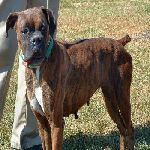

In [118]:
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
img

In [119]:
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model_test.layers]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


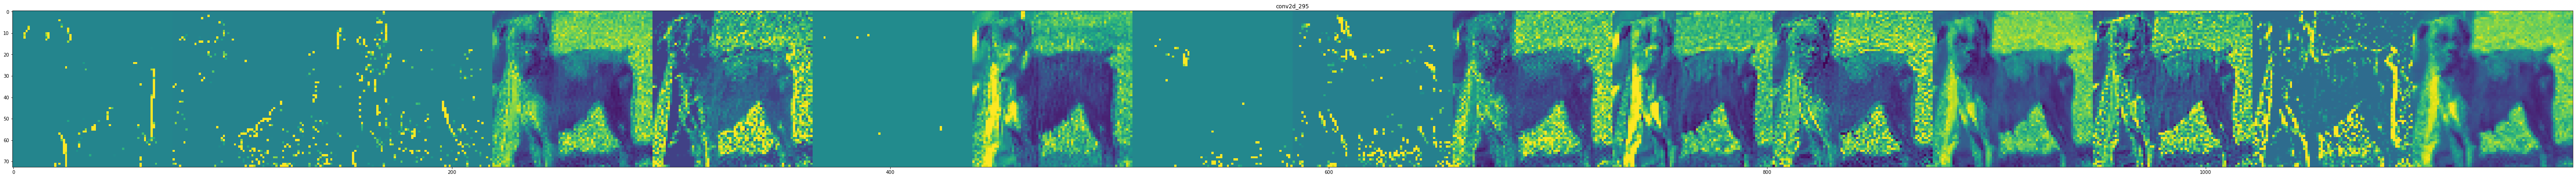

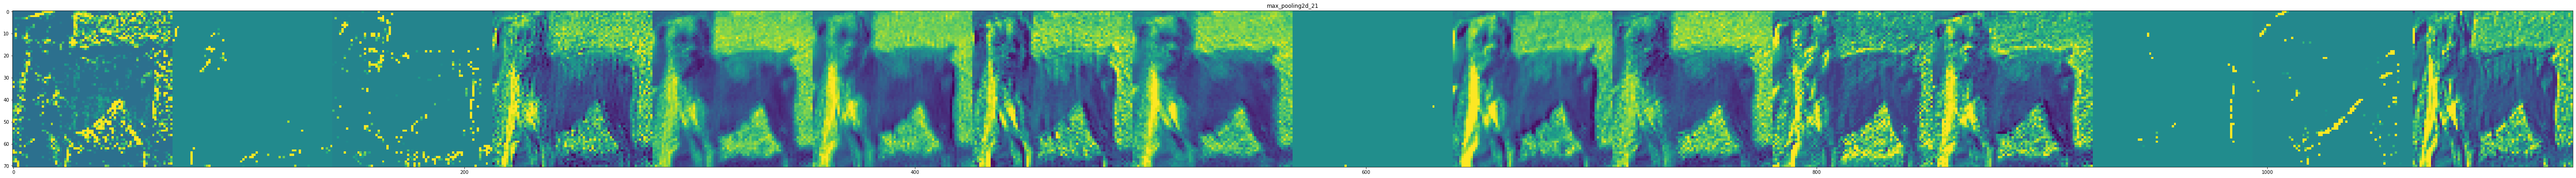

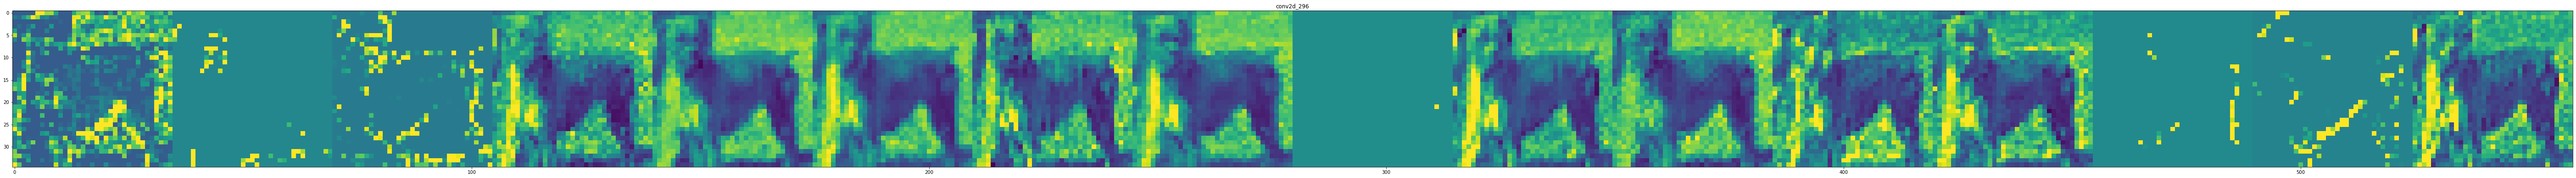

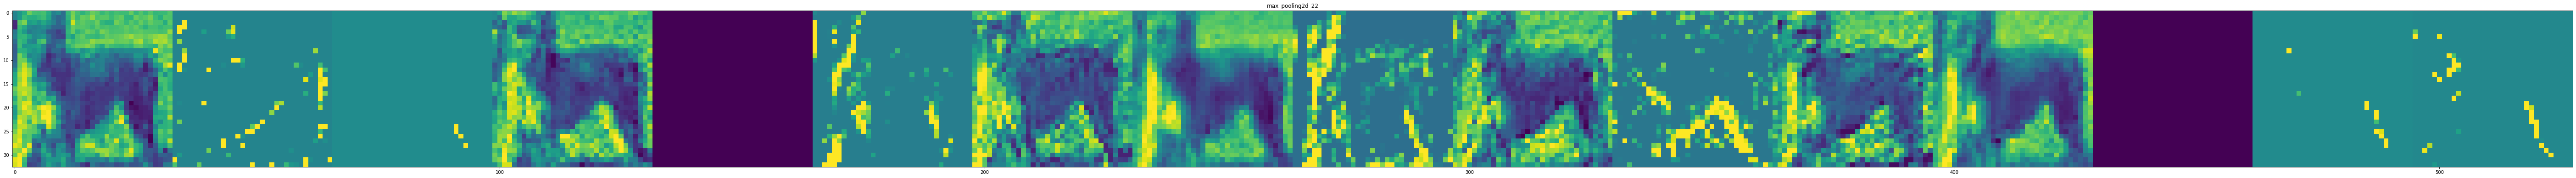

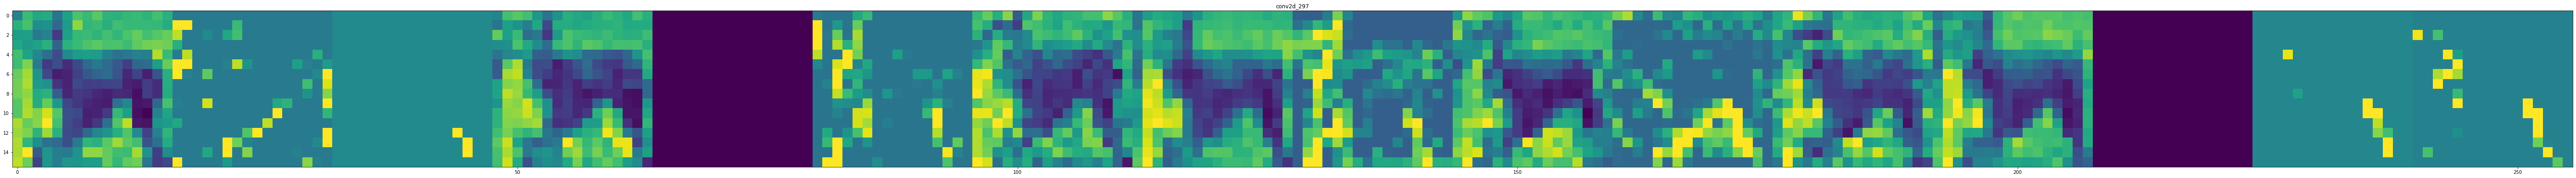

In [121]:
# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    n_features = int(n_features/2)      # decrease the number of features to be plotted
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 100. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 